# Introduction to Transform objects

This Jupyter notebook includes an introduction to Transform objects, and worked examples below.

Transform is a general-purpose framework to represent, manipulate, and use coordinate transformations on scientific data.  A Transform object represents a coordinate transformation mapping $ ℝ^{N} $ -> $ ℝ^{M} $ , for integers $ N $ and $ M $.  Subclasses of Transform represent families of transformation, which can be parameterized at construction time. Instances of Transform represent individual coordinate transformations, which are fixed but can be composed, inverted, applied, or used to resample or remap array data such as images.

The transform core module includes a WCS object that allows you to work with World Coordinate System transformations mapping pixel index values in an image to/from scientific coordinates associated with that image.  WCS is a standard for metadata in scientific imaging, and is used throughout the astronomy and heliophysics scientific communities, but it is sufficiently general for other applications as well.

This notebook includes demonstrations of basic Transform construction and manipulation, and shows how Transforms can be applied to image data to remap/resample them.

**Why use Transform?** There are other coordinate transformation packages in the Python universe, but none appear sufficiently general to support general-purpose vector manipulation in N dimensions. The `astropy.wcs` package, in particular, has objects that represent various celestial coordinate systems and a collection of specific coordinate-transformation methods to convert between them.  The `matplotlib` plotting library supports 2-D coordinate transformations and has a framework to manipulate them, but they do not generalize easily to arbitrary dimensions.  Transform is specifically written to be non-specific to any one application.  Even the use of WCS doesn't strongly constrain application:  WCS supports general purpose affine transformations to arbitrary world coordinates in any array, in addition to its more specialized astronomical coordinate systems. 

## Basics

### Manipulating Vectors

In general, Transforms apply to vector data and return a modified version of the supplied vector(s).  Most Transforms supply both forward and reverse operations, and can be inverted or explicitly applied in the reverse direction.  Some coordinate transformations are not invertible, so it is possible for a Transform to have only a forward operation or only a reverse operation.  

Given a Transform object (see below for examples), you can use it to manipulate vector data using the `apply` method.  Apply accepts one or more vectors as a list-like object, and returns the transformed vectors.

#### Vectors and broadcasting

Vectors are Python "list-like objects" (typically NumPy arrays) that you supply with indices in conventional order (X,Y,...).  Because of the way NumPy broadcast rules work, by convention Transform objects expect the vector index to run across the *last* dimension of a supplied NumPy array.  So in general, a coordinate transform that expects to operate on 2-vectors can operate in a (heh) vectorized manner on any NumPy array whose last dimension has a size of 2 or more. If you supply the Transform with a NumPy array whose shape is
`[1000,1000,2]`, you'll get the same operation applied a million times -- once per 2-vector in the source array.  

#### Dimensionality of a transform

Individual Transform subclasses or instances can define the dimensionality of the vectors they expect to 
receive and/or generate.  These are carried in the `idim` and `odim` attributes, which may contain 0 to indicate that the Transform can operate on vectors of any size, or a positive integer to indicate the 
dimensionality of the vector.  

In general, if you feed in a higher dimensional vector than a transform expects, the additional dimensions are preserved untouched -- so if you have a coordinate transformation that expects a 2-D input vector and projects it to 1-D, then a 3-D input vector will be projected to 2-D (and the additional components are preserved untouched at the end of the manipulated components of the vector).

#### Projections and embeddings

A `Transform` whose output dimensionality (`odim`) is lower than its input dimensionality (`idim`) is a *projection*: it reduces the dimensionality of its input vector(s).  

A `Transform` whose `odim` is higher than its `idim` is an *embedding*: it increases the dimensionality of their input vectors by embedding them on a manifold in the higher dimension.

Projections may have formal inverses that embed onto a specific manifold, and therefore are not mathematical inverses.  An example is projection of 3-D points into 2-D plate caree (lon,lat) coordinates:  its inverse deprojects 2-D plate caree coordinates onto the unit sphere.

### Resampling and Remapping Arrays

Transforms can also be used to remap array data, by manipulating the pixel coordinate system in the data.

#### Pixel coordinate system; NumPy reverse indexing

Array data such as images have an implicit coordinate system.  Each pixel of an image is associated with a 2-vector indicating its location in the pixel grid.  Following NumPy convention, indexing is in *reverse* order: while the vector data manipulated by `apply` is in (X,Y) order, images and other data are considered to be indexed in (Y,X) order, with X increasing to the right and Y increasing upward.  

#### Resampling in the pixel coordinate system 

You can use Transform objects to change the shape of data within their pixel grid: notionally, the coordinate transformation is applied to each pixel's coordinate vector, and the data value moves to the new location in the pixel grid.  This resampling is implemented via the inverse of the Transform: every pixel grid location in the output image is mapped backward to a location on the input grid, and a data value is interpolated from the input at that location.  Resampling is implemented with the `resample` method (below).  

#### Remapping in a scientific coordinate system

You can also use transform objects to manipulate the scientific coordinates of data in an image, using the framework of Astropy support for the World Coordinate System standard.  This adds one level of indirection to resampling: you can distort, transform, tweak, or scale images in their original scientific coordinate system rather than in the implicit pixel grid coordinate system.  Remapping in this way is implemented with the `remap` method.

## Transform API methods

Transforms tightly encapsulate the messiness of general coordinate transformation.  Each Transform object has only a few methods:

- **_Constructor_**: Each Transform subclass has a constructor.  You should always construct a subclass - Transform itself is only a container/superclass.

- **`apply`**: This applies the Transform to vector data, returning a modified version of the input vectors.  In addition to the Transform itself, you supply the vector data and an optional `invert` flag indicating whether the forward or reverse transformation is to be applied.

- **`invert`**: This applies the inverse of the Transform to vector data.  It's equivalent to setting the `invert` flag in `apply()`.

- **`inverse`**: This returns a different Transform that implements the inverse of the original.

- **`composition`**: This returns the composition of this Transform with some others

- **`resample`**: This uses the Transform to resample a NumPy array or similar object in its intrinsic pixel coordinate system.  There are several options that control the shape of the output array, the interpolation method, and any boundary conditions to apply.

- **`remap`**: This uses the Transform to resample a NumPy array or similar object in an associated scientific coordinate system.  It makes use of a FITS header or astropy.wcs object to associate a scientific coordinate system with the array.  You can supply the data in any one of several common formats:  a tuple containing (data, header); a dictionary containing data and header fields; or a generic object containing data and header attributes.  Remap will try to give you back the data in the same format you supplied it, if possible.  Remap will autoscale the output so that the input range fits in the output pixel plane, and return a WCS header that reflects the scaling.  There are several options controlling the shape and scaling of the output array, the interpolation method, and boundary conditions.

## Transform core and basic subclasses

Each subclass represents a family of coordinate transforms.  The Transform package includes core subclasses that are required to define the functionality of Transforms themselves, and also basic subclasses that implement a few of the most commonly used transformations.

The **core subclasses** are included in the module `transform.core`.  They are required to implement the core functionality of transforms:

- **`Identity`**: (idim=0; odim=0) The identity transform does nothing and is idempotent (its own inverse).  It has no preferred dimensionality.  It is useful as a placeholder and for testing.

- **`Inverse`**: (idim=\*; odim=\*) This is a functional inverse of a single `Transform`.  While `Inverse` objects work correctly on all `Transforms`, it is better to use the `.inverse` method, which avoids double-inversing and idempotence.  Input and output dims depend on the supplied `Transform`.

- **`Composition`**: (idim=\*; odim=\*) This composes a list of `Transform`s together in mathematical order (i.e. they are executed right-to-left in the list).  Input and output dims depend on the supplied `Transform`s.

- **`Wrap`**: (idim=\*; odim=\*) This is syntactic sugar for a Composition of the form $ W^{-1} o T o W $, which is a common construction for modifying coordinate transformations.

- **`WCS`**: (idim=\*; odim=\*) This implements the World Coordinate System as implemented by `astropy.wcs`.  The constructor accepts one of several common object/data types (as implemented by `DataWrapper`, below) and returns a `Transform` that maps image pixel coordinates to scientific coordinates.  `WCS` is part of the core, because it is used by the `remap()` method to convert between pixel and scientific coordinates.

The **basic subclasses** are included in `transform.basic`.  They implement a few of the most common coordinate transforms:

- **`Linear`** (idim=\*; odim=\*) This is the most basic affine/linear transform, implementing a shift and a matrix multiplication.  It has several subclasses:

    - **`Scale`** implements scalar multiplication or diagonal matrices
    
    - **`Rotation`** implements rotation in N-D via generalized Euler angles
    
    - **`Offset`** implements simple offsets (no matrix operation)
 
- **`Radial`** (idim=2; odim=2) Radial/polar coordinate conversion.  By default, the angular coordinate runs clockwise to preserve image chirality.  Because higher dimensions are passed through, this also implements cylindrical coordinates in 3-D.

- **`Spherical`** (idim=3; odim=3) Spherical coordinate conversion.

- **`Pincushion`** (idim=2; odim=2) Polynomial Pincushion/Barrel distortion in optical systems **not yet implemented**

- **`Projective`** (idim=2; odim=2) Projective transforms are linear transformations in _homogeneous coordinates_.  **not yet implemented**

## Examples 

### Loading Transform

Transform works closely with numpy and with FITS objects, so you will want to import those modules up-front for convenience.  Also pyplot, to show stuff.

In [2]:
import numpy as np
import astropy.io.fits
import transform as t
import matplotlib.pyplot as pl

### Vector manipulation with simple Transforms

This section displays some simple examples of manipulating vectors with included basic Transforms.  The vectors being manipulated can represent literally any vector quantity -- for example: location in a plane or 3-space, rotation angle, generalized coordinates of a physical system, state of a quantum particle, optical polarization, color, or eigenface characteristics of an image.

#### Simple scaling and inverses

First define a simple 2-D transform: linear scaling by 1.5 in the X direction and 2 in the Y direction, then apply it to a vector. 

In [3]:
trans = t.Scale([1.5,2])
print(f"trans is a '{trans}'")

trans is a 'Transform( Linear/Scale ([1.5 2. ]) )'


In [4]:
a = np.array([1,1])
b = trans.apply(a)
print(f"{a} mapped to {b}")

[1 1] mapped to [1.5 2. ]


You can map a collection of vectors all at once.  The *last* (innermost) dimension is the dimension acted on by the Transform.  All ealier dimensions are broadcast.

In [5]:
a = np.array([[1,1],[1,2],[2,1],[2,2]])
b = trans.apply(a)
print(f"a has shape {a.shape}; its value is:\n{a}\n")
print(f"b has shape {b.shape}; its value is:\n{b}\n")

a has shape (4, 2); its value is:
[[1 1]
 [1 2]
 [2 1]
 [2 2]]

b has shape (4, 2); its value is:
[[1.5 2. ]
 [1.5 4. ]
 [3.  2. ]
 [3.  4. ]]



You can undo the transformation by inverting it directly, or by generating an inverse Transform and applying that.  Both `c` and `d` should end up with the same value as `a`, since both the forward and inverse scale are applied:

In [6]:
c = trans.invert(b)
itrans = trans.inverse()
d = itrans.apply(b)
print(f"a is \n{a}")
print(f"c is \n{c}")
print(f"d is \n{d}")

a is 
[[1 1]
 [1 2]
 [2 1]
 [2 2]]
c is 
[[1. 1.]
 [1. 2.]
 [2. 1.]
 [2. 2.]]
d is 
[[1. 1.]
 [1. 2.]
 [2. 1.]
 [2. 2.]]


#### Transformation compositions

You can compose transformations to get something more complicated.  Here we construct a rotation by 30 degrees, and show how it composes with different offsets, by manipulating the corners of a unit square with one corner at the origin.

Text(0.5, 1.0, 'A simple square')

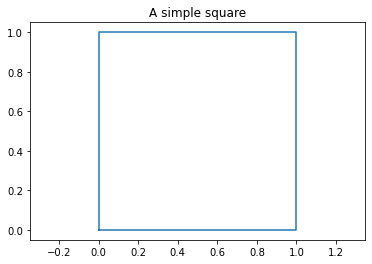

In [7]:
a = np.array([[0,0],[1,0],[1,1],[0,1],[0,0]])
p = pl.subplot()
p.plot(a[...,0],a[...,1])
p.axis('equal')
p.set_title("A simple square")

a_rot30 is:
[[ 0.         0.       ]
 [ 0.8660254  0.5      ]
 [ 0.3660254  1.3660254]
 [-0.5        0.8660254]
 [ 0.         0.       ]]


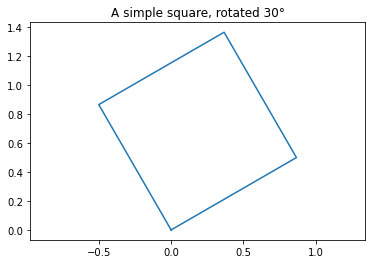

In [8]:
rotation = t.Rotation(30,unit='deg')
a_rot30 = rotation.apply(a)

print(f"a_rot30 is:\n{a_rot30}")
p=pl.subplot()
p.plot(a_rot30[...,0],a_rot30[...,1])
p.axis('equal')
p.set_title("A simple square, rotated 30°")

The rotation happens around the origin.  You can rotate the square around its center by offsetting it first to place the origin where you want it, and putting it back after.  There are a couple of ways to do that.  The most obvious way is to build an offset transformation O and wrap it around the rotation in a composition:  $ C = O^{-1} o R o O $.  You can do that directly or with the Wrap constructor, both of which do the same thing:

compound1 = Transform( ( (Inverse Linear/Offset) o (Linear/Rotation) o (Linear/Offset) ) )
compound2 = Transform( ( (Inverse Linear/Offset) o (Linear/Rotation) o (Linear/Offset) ) )


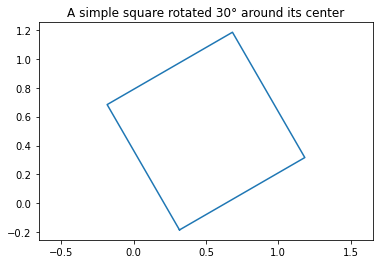

In [9]:
offset = t.Offset([-0.5,-0.5])
compound1 = t.Composition( [ offset.inverse(), rotation, offset ] )
compound2 = t.Wrap(rotation, offset)

print(f"compound1 = {compound1}")
print(f"compound2 = {compound2}")
a_rot30_ctr = compound1.apply(a)
p = pl.subplot()
p.plot( a_rot30_ctr[...,0], a_rot30_ctr[...,1] )
p.axis('equal')
p.set_title("A simple square rotated 30° around its center")

(Note, here, that the square's lower left corner is no longer at (0,0): the square has been rotated around its center at (0.5,0.5).).  For this specific application you don't have to use a compound transform at all: the Linear subclasses (Rotation is one of them) all support separate pre-rotation and post-rotation offsets:

<function matplotlib.pyplot.show(close=None, block=None)>

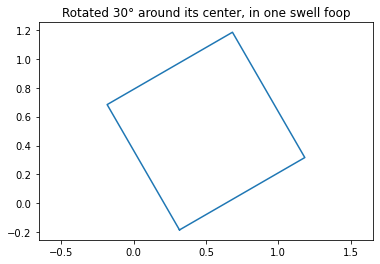

In [10]:
rot30_center = t.Rotation(30,unit='deg',pre=[-0.5,-0.5],post=[0.5,0.5])
a_rot30_ctr_direct = rot30_center.apply(a)

p = pl.subplot()
p.plot( a_rot30_ctr_direct[...,0], a_rot30_ctr_direct[...,1] )
p.axis('equal')
p.set_title("Rotated 30° around its center, in one swell foop")

You can compose the Transform with itself to rotate the square 60°:

<function matplotlib.pyplot.show(close=None, block=None)>

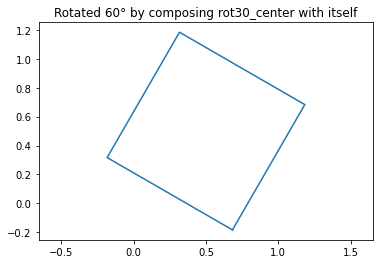

In [11]:
a_rot60 = rot30_center.composition(rot30_center).apply(a)

p = pl.subplot()
p.plot( a_rot60[...,0], a_rot60[...,1] )
p.axis('equal')
p.set_title('Rotated 60° by composing rot30_center with itself')

### Resampling image or array data in pixel coordinates

You can use Transforms to resample arrays or images to different form factors, or to distort them.  For that you use the `resample()` method, which produces an output array containing the resampled data.  The algorithm is:  

- Enumerate the integer vector coordinates in every point of the output array

- Apply the inverse transform to map each output array point to a floating-point location in the input array

- Interpolate the value of the input array at each inverse-transformed point, and place the interpolated value in the output array

Resample accepts a shape parameter for the output array, or defaults to the input array shape.  You can also specify boundary conditions along each axis, to handle points that land outside the bounds of the input array.  Boundary conditions are: "forbid", "truncate", "extend", "periodic", and "mirror".  You can specify them independently along each axis.

#### Simple manipulation of a small test array

First, define a 7x7 array of pixels.  Remember: X "looks right" on the screen but Y is backward.

Text(0.5, 1.0, 'A 7x7 test image')

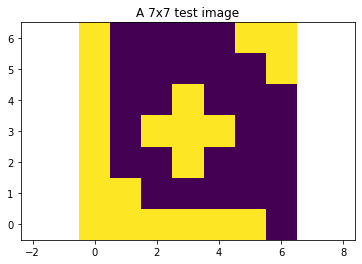

In [13]:
a = np.array([[1,1,1,1,1,1,0],
              [1,1,0,0,0,0,0],
              [1,0,0,1,0,0,0],
              [1,0,1,1,1,0,0],
              [1,0,0,1,0,0,0],
              [1,0,0,0,0,0,1],
              [1,0,0,0,0,1,1]
             ])

p = pl.subplot()
p.imshow(a,origin='lower')
p.axis('equal')
p.set_title('A 7x7 test image')

We can upsample by a scalar factor of 20, by scaling up 20x and supplying a 140x140 shape.  We have to supply an 0.5-pixel offset because the origin (0,0) is considered to be at the *center* of the lower left pixel.

Text(0.5, 1.0, 'Upsampled 20x with Hann windows')

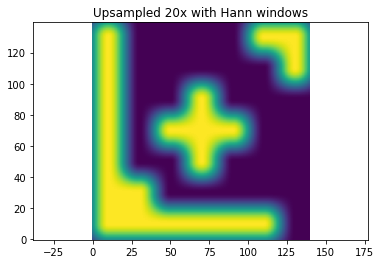

In [17]:
t_sc = t.Scale(20,pre=[0.5,0.5])
b = t_sc.resample(a, shape=[140,140], method='hann')

p = pl.subplot()
p.imshow(b,origin='lower')
p.axis('equal')
p.set_title('Upsampled 20x with Hann windows')


With a less aggressive upsample we can demonstrate boundary condition handling.  Here's a 10x upsample with linear interpolation and vertical offset.  The horizontal (X) direction has mirrored boundary conditions, and the vertical (Y) direction has extended boundaries:

Text(0.5, 1.0, 'Upsampled 10x; mirror and extend boundaries')

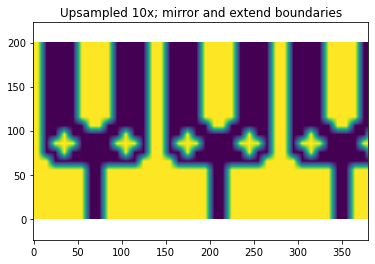

In [25]:
t_sc = t.Scale(10,pre=[0.5,0.5],post=[0,50])
b = t_sc.resample(a,shape=[200,380], method='linear',bound=['m','e'])

p = pl.subplot()
p.imshow(b,origin='lower')
p.axis('equal')
p.set_title('Upsampled 10x; mirror and extend boundaries')


The central "+" is duplicated five times along the X axis, and subsequent images are left/right reversed due to the mirror boundary conditions.  In the vertical direction the closest available value is extended above and below the original boundaries of the image.

Text(0.5, 1.0, 'Radialized')

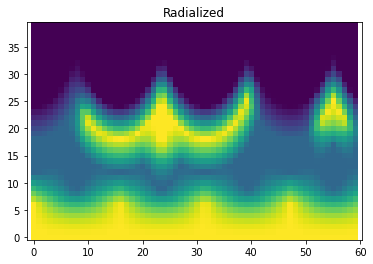

In [32]:
t_rad = t.Composition([t.Scale([10,6]),t.Radial(origin=[3,3],pos_only=True)])
c = t_rad.resample(a+0.5,shape=[40,60],method='linear',bound='truncate')

p=pl.subplot()
p.imshow(c,origin='lower')
p.axis('equal')
p.set_title('Radialized')

The image is in polar coordinates.  The four peaks at bottom are the four spikes in the central "+" of the image.  The "w" shape centered above column 24 is the right angle at lower left of the original image, and the small inverted "v" around column 55 is the smaller right angle in the opposite corner.  The Radial transform has horizontal origin pointing horizontally to the right, and sweeps *clockwise* by default.  The Scale expands radians by a factor of 10, so each pixel is 0.1 radian, and also stretches the radius by a factor of 6 to oversample the original.